In [1]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import findspark
from math import radians, cos, sin, asin, sqrt
from pyspark import SparkContext
from pyspark.sql import SparkSession 
from pyspark.sql.functions import array
sc=SparkContext()

23/04/14 11:43:34 WARN Utils: Your hostname, Jasmines-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.110.94.25 instead (on interface en0)
23/04/14 11:43:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/14 11:43:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
@udf()
def haversine_to_cape(lat_long):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = map(radians, (28.3922, -80.6077))
    lat2, lon2 = map(radians, [float(i) for i in lat_long])

    #haversine formula i 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [3]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

df_1986 = spark.read.csv('1986.csv')
df_stations = spark.read.csv('stations.csv')

In [4]:
df_1986 = df_1986.dropDuplicates()

In [5]:
df_stations = df_stations.dropna(subset=["_c2","_c3"])
df_stations = df_stations.dropDuplicates()

In [6]:
df_stations = df_stations.withColumn("distance_to_cape", haversine_to_cape(array('_c2', '_c3')))

In [7]:
distance_df = df_stations.filter(df_stations.distance_to_cape <= 100)
distance_df.show()

+------+-----+-------+--------+------------------+
|   _c0|  _c1|    _c2|     _c3|  distance_to_cape|
+------+-----+-------+--------+------------------+
|747940|12868|+28.483|-080.567|10.852471594053252|
|722011|92813|+28.290|-081.437| 81.95247639646107|
|722058| null|+29.070|-080.920| 81.28688869720159|
|  null|12851|+28.100|-080.633| 32.58553314315834|
|720904| null|+29.067|-081.284| 99.89303332812807|
|749047| null|+28.283|-081.416| 80.03461347256854|
|  null|12843|+27.653|-080.243| 89.65245500958036|
|720904|00299|+29.067|-081.283| 99.82869362421721|
|747945| null|+28.617|-080.700|26.573973942086713|
|997354| null|+28.420|-080.580| 4.110433692817337|
|722361|92808|+29.054|-080.948| 80.72444804718191|
|722053| null|+28.550|-081.333| 73.03467496332385|
|722045|12843|+27.653|-080.243| 89.65245500958036|
|994951| null|+27.862|-080.445| 61.07628026769421|
|997806| null|+28.400|-080.533| 7.358154613618123|
|722040| null|+28.100|-080.650| 32.75429010493698|
|  null|12855|+27.650|-080.417|

In [8]:
distance_df = distance_df.withColumnRenamed("_c0","Station_ID")
distance_df = distance_df.withColumnRenamed("_c1","WBAN_ID")
distance_df = distance_df.withColumnRenamed("_c2","Latitude")
distance_df = distance_df.withColumnRenamed("_c3","Longitude")

distance_df.show()

+----------+-------+--------+---------+------------------+
|Station_ID|WBAN_ID|Latitude|Longitude|  distance_to_cape|
+----------+-------+--------+---------+------------------+
|    747940|  12868| +28.483| -080.567|10.852471594053252|
|    722011|  92813| +28.290| -081.437| 81.95247639646107|
|    722058|   null| +29.070| -080.920| 81.28688869720159|
|      null|  12851| +28.100| -080.633| 32.58553314315834|
|    720904|   null| +29.067| -081.284| 99.89303332812807|
|    749047|   null| +28.283| -081.416| 80.03461347256854|
|      null|  12843| +27.653| -080.243| 89.65245500958036|
|    720904|  00299| +29.067| -081.283| 99.82869362421721|
|    747945|   null| +28.617| -080.700|26.573973942086713|
|    997354|   null| +28.420| -080.580| 4.110433692817337|
|    722361|  92808| +29.054| -080.948| 80.72444804718191|
|    722053|   null| +28.550| -081.333| 73.03467496332385|
|    722045|  12843| +27.653| -080.243| 89.65245500958036|
|    994951|   null| +27.862| -080.445| 61.0762802676942

In [9]:
df_1986 = df_1986.withColumnRenamed("_c0","Station_ID")
df_1986 = df_1986.withColumnRenamed("_c1","WBAN_ID")
df_1986 = df_1986.withColumnRenamed("_c2","Month")
df_1986 = df_1986.withColumnRenamed("_c3",'Day')
df_1986 = df_1986.withColumnRenamed("_c4",'Temperature')

df_1986.show()

+----------+-------+-----+---+-----------+
|Station_ID|WBAN_ID|Month|Day|Temperature|
+----------+-------+-----+---+-----------+
|    010750|   null|   12| 01|       23.7|
|    011160|   null|   05| 01|       43.7|
|    011600|   null|   10| 01|       47.9|
|    012280|   null|   01| 01|       24.5|
|    013110|   null|   11| 01|       40.8|
|    013660|   null|   06| 01|       38.2|
|    014033|   null|   05| 01|       45.1|
|    021860|   null|   11| 01|       39.5|
|    021960|   null|   01| 01|       23.9|
|    025240|   null|   09| 01|       51.4|
|    025300|   null|   10| 01|       53.5|
|    025920|   null|   08| 01|       66.6|
|    029150|   null|   05| 01|       39.0|
|    031520|   null|   09| 01|       53.1|
|    033450|   null|   01| 01|       34.6|
|    033790|   null|   04| 01|       42.7|
|    034140|   null|   11| 01|       45.3|
|    034925|   null|   05| 01|       58.3|
|    035030|   null|   09| 01|       57.6|
|    035623|   null|   01| 01|       36.9|
+----------

In [10]:
merged_df = distance_df.join(df_1986, (distance_df["Station_ID"] == df_1986["Station_ID"]) |
                             (distance_df["WBAN_ID"] == df_1986["WBAN_ID"]), 'inner')

merged_df.show()

+----------+-------+--------+---------+-----------------+----------+-------+-----+---+-----------+
|Station_ID|WBAN_ID|Latitude|Longitude| distance_to_cape|Station_ID|WBAN_ID|Month|Day|Temperature|
+----------+-------+--------+---------+-----------------+----------+-------+-----+---+-----------+
|    722050|  12815| +28.434| -081.325|70.30590142260303|    722050|  12815|   12| 08|       69.2|
|      null|  12815| +28.434| -081.325|70.30590142260303|    722050|  12815|   12| 08|       69.2|
|    722053|  12841| +28.545| -081.333|72.90473375184327|    722051|  12841|   03| 09|       11.8|
|      null|  12841| +28.545| -081.333|72.90473375184327|    722051|  12841|   03| 09|       11.8|
|    722051|  12841| +28.545| -081.333|72.90473375184327|    722051|  12841|   03| 09|       11.8|
|    722050|  12815| +28.434| -081.325|70.30590142260303|    722050|  12815|   12| 17|       66.0|
|      null|  12815| +28.434| -081.325|70.30590142260303|    722050|  12815|   12| 17|       66.0|
|    72205

In [11]:
from pyspark.sql.functions import pow, sum, col

# Calculate the weights using the inverse distance weighting formula
p = 2  # power parameter
data = merged_df.withColumn("weight", 1 / pow(merged_df.distance_to_cape, p))

# Calculate the weighted average temperature
weighted_avg_temperature = data.select(sum(data.Temperature * data.weight) / sum(data.weight)).collect()[0][0]

# Print the result
print(f"The estimated temperature at Cape Canaveral on January 28, 1986 is {weighted_avg_temperature:.2f} degrees.")


The estimated temperature at Cape Canaveral on January 28, 1986 is 72.73 degrees.


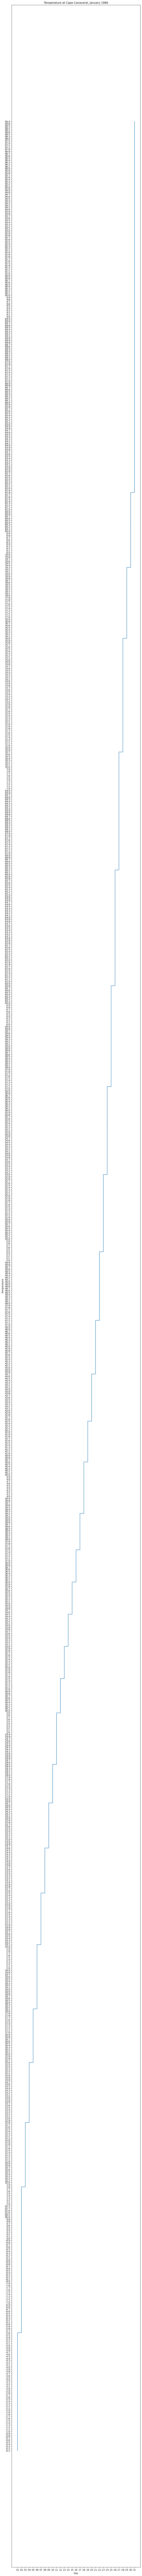

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# filter the DataFrame to include only the data for January 1986
january_1986_df = df_1986.filter(df_1986['Month'] == '01')

# extract the day and temperature data from the filtered DataFrame
data = january_1986_df.toPandas()

# sort the data by the 'Day' column
data_temp = data.sort_values(by='Temperature', ascending=True)
data_day = data.sort_values(by='Day', ascending=True)
# plot the temperature data as a scatter plot
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['path.simplify_threshold'] = 1.0
plt.figure(figsize=(10, 200))
plt.plot(data_day['Day'], data_temp['Temperature'])
plt.title('Temperature at Cape Canaveral, January 1986')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.savefig('nasa_graph.pdf', bbox_inches='tight')
plt.show()

The visualization shows the variations of the temperature in Fahrenheit on a daily basis over the 30 days in January. The temperature seems to steadily increase by a step each day with the highest recorded temperature recorded on the last day of the month. If the NASA did not launch the challenger on the day it did, January 28th, but a few days after the outcome may have been starkly different.  The temperature recorded on January 28th was 76. 1 Fahrenheit and the days following it the temperature rises to about 81.8 degrees. A higher temperature would have not caused the fatal issue of the rubber seals losing their resiliency, and ultimately causing the explosion.